In [71]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pydub import AudioSegment
import numpy as np
import io
from scipy import stats
import random
from tqdm import tqdm

# plt use ggplot stylesheet
plt.style.use('ggplot')

In [34]:
with open('temp/image-scoring-cogsci-data.json', 'r') as f:
    data = json.load(f)
    data = [entry for entry in data if entry.get('trial_type') == 'img-synth-response-anim']

print(f'Found {len(data)} sound trials')

Found 2344 sound trials


In [35]:
musical_trials = [entry for entry in data if entry.get('session_info', {}).get('condition') == 'musical']
referential_trials = [entry for entry in data if entry.get('session_info', {}).get('condition') == 'referential']
print(f'Found {len(musical_trials)} musical condition sounds')
print(f'Found {len(referential_trials)} referential condition sounds')

Found 1171 musical condition sounds
Found 1173 referential condition sounds


## interface interactions

In [ ]:
heatmap_resolution = 6
canvas_size = 400  # pixels, set in jspsych experiment code

musical_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
referential_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
musical_xvals = []
musical_yvals = []
referential_xvals = []
referential_yvals = []

for entry in musical_trials:
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    musical_heatmap[y_bin, x_bin] += 1
                    musical_xvals.append(x)
                    musical_yvals.append(y)

for entry in referential_trials:
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    referential_heatmap[y_bin, x_bin] += 1
                    referential_xvals.append(x)
                    referential_yvals.append(y)

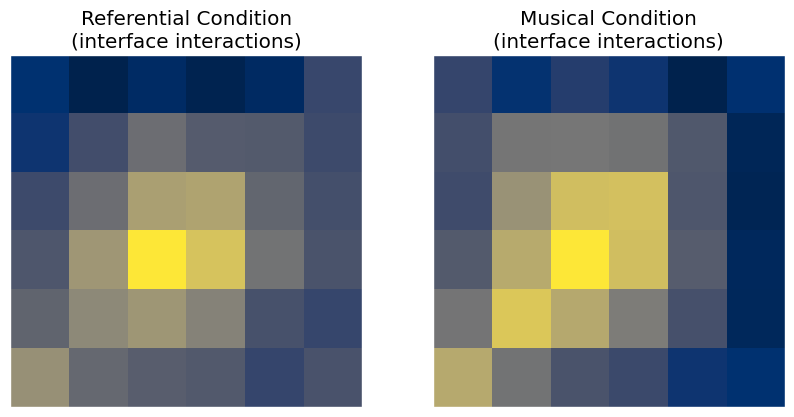

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(referential_heatmap, cmap='cividis', interpolation='nearest')
plt.title('Referential Condition\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(musical_heatmap, cmap='cividis', interpolation='nearest')
plt.title('Musical Condition\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.show()

In [38]:
corr = np.corrcoef(referential_heatmap.flatten(), musical_heatmap.flatten())[0, 1]
print(f'Correlation: r = {corr:.3f}')

Correlation: r = 0.893


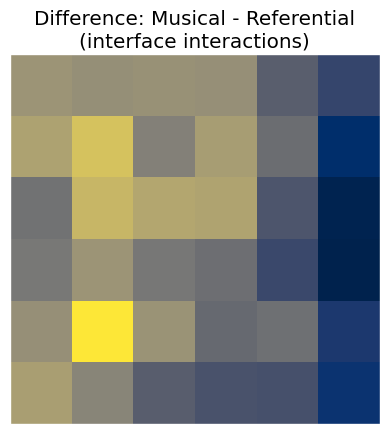

In [39]:
plt.imshow(musical_heatmap - referential_heatmap, cmap='cividis', interpolation='nearest')
plt.title('Difference: Musical - Referential\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.show()

### pitch space and vibrato space distributions

In [40]:
print(f'number of musical interactions: {len(musical_xvals)}')
print(f'number of referential interactions: {len(referential_xvals)}')

number of musical interactions: 169322
number of referential interactions: 188287


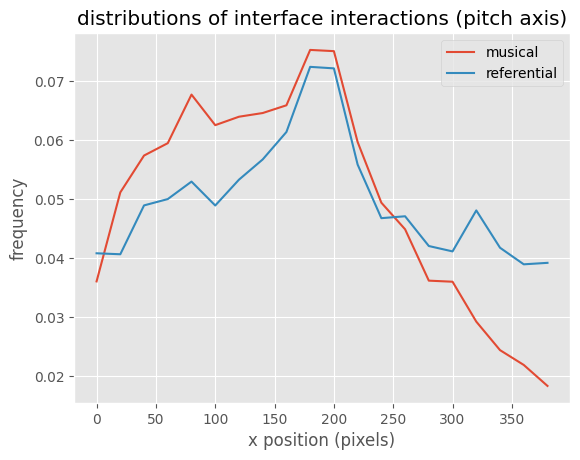

In [41]:
musical_pitch_hist = np.histogram(musical_xvals, bins=20, range=(0, canvas_size))
plt.plot(musical_pitch_hist[1][:-1], musical_pitch_hist[0]/len(musical_xvals), label='musical')
referential_pitch_hist = np.histogram(referential_xvals, bins=20, range=(0, canvas_size))
plt.plot(referential_pitch_hist[1][:-1], referential_pitch_hist[0]/len(referential_xvals), label='referential')
plt.xlabel('x position (pixels)')
plt.ylabel('frequency')
plt.title('distributions of interface interactions (pitch axis)')
plt.legend()
plt.show()

In [76]:
# compute 1D Earth Mover's Distance (Wasserstein) between x-position distributions
emd_x = stats.wasserstein_distance(musical_xvals, referential_xvals)
print(f'earth mover distance (pitch axis, pixels): {emd:.3f}')

earth mover distance (pitch axis, pixels): 3.389


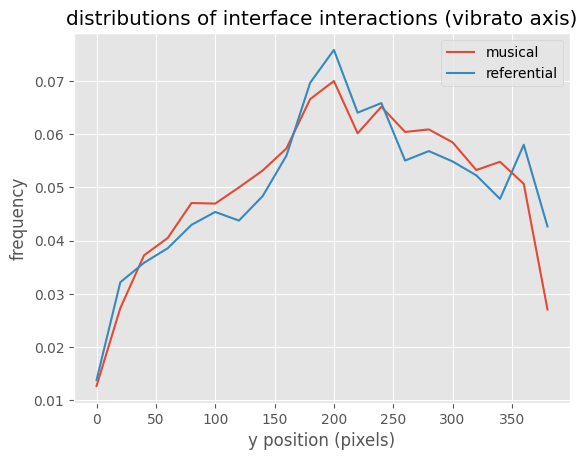

In [43]:
musical_vibrato_hist = np.histogram(musical_yvals, bins=20, range=(0, canvas_size))
plt.plot(musical_vibrato_hist[1][:-1], musical_vibrato_hist[0]/len(musical_yvals), label='musical')
referential_vibrato_hist = np.histogram(referential_yvals, bins=20, range=(0, canvas_size))
plt.plot(referential_vibrato_hist[1][:-1], referential_vibrato_hist[0]/len(referential_yvals), label='referential')
plt.xlabel('y position (pixels)')
plt.ylabel('frequency')
plt.title('distributions of interface interactions (vibrato axis)')
plt.legend()
plt.show()

In [74]:
# compute 1D Earth Mover's Distance (Wasserstein) between y-position distributions
emd_y = stats.wasserstein_distance(musical_yvals, referential_yvals)
print(f'earth mover distance (vibrato axis, pixels): {emd:.3f}')

earth mover distance (vibrato axis, pixels): 3.389


### shuffle participant labels for null distribution

In [93]:
n_shuffles = 200

In [ ]:
x_EMDs = []
y_EMDs = []

for _ in tqdm(range(n_shuffles)):
    crossgroup_shuffled_participants = [[],[]]
    for trial in data:
        random_group = np.random.choice([0, 1])
        crossgroup_shuffled_participants[random_group].append(trial)

    shuffled_xvals_0 = []
    shuffled_xvals_1 = []
    shuffled_yvals_0 = []
    shuffled_yvals_1 = []
    
    for group in crossgroup_shuffled_participants:
        for entry in group:
            for performance in entry.get('performances', []):
                for event in performance.get('interactions', []):
                    if event.get('type') == 'mousemove':
                        x = event.get('x')
                        y = event.get('y')
                        if x is not None:
                            if group == crossgroup_shuffled_participants[0]:
                                shuffled_xvals_0.append(x)
                                shuffled_yvals_0.append(y)
                            else:
                                shuffled_xvals_1.append(x)
                                shuffled_yvals_1.append(y)
    
    x_EMD = stats.wasserstein_distance(shuffled_xvals_0, shuffled_xvals_1)
    x_EMDs.append(x_EMD)
    y_EMD = stats.wasserstein_distance(shuffled_yvals_0, shuffled_yvals_1)
    y_EMDs.append(y_EMD)

  2%|▏         | 3/200 [00:01<01:35,  2.05it/s]

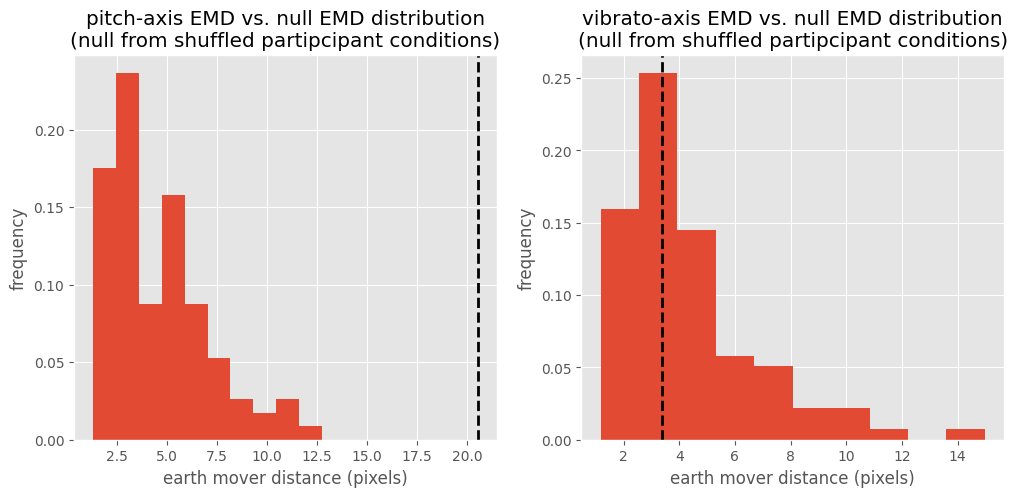

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(x_EMDs, bins=10, density=True)
plt.axvline(emd_x, color='k', linestyle='dashed', linewidth=2)
plt.title('pitch-axis EMD vs. null EMD distribution\n(null from shuffled partipcipant conditions)')
plt.xlabel('earth mover distance (pixels)')
plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.hist(y_EMDs, bins=10, density=True)
plt.axvline(emd_y, color='k', linestyle='dashed', linewidth=2)
plt.title('vibrato-axis EMD vs. null EMD distribution\n(null from shuffled partipcipant conditions)')
plt.xlabel('earth mover distance (pixels)')
plt.ylabel('frequency')
plt.show()